# Cliff Walking: Understanding SARSA vs Q Learning

 March 8 2025

# Temporal Difference Learning

## Learning from movement 

- ### SARSA: *State*, *Action*, *Reward*, *State*, *Action*
- ### Q Learning: *State*, *Action*, *Reward*, *State*, ?

In [40]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [41]:
SARSA = "sarsa"
Q_LEARNING = "q_learning"

In [9]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array_list")

In [10]:
class CliffAgent:

    def __init__(self, env):

        self.env = env
        self.policy = None
        self.reset()

        self.step_size = 0.5
        self.discount = 1
        self.strategy = SARSA

        self.S = None
        self.A = None

    def set_policy(self, policy):
        self.policy = policy

    def set_strategy(self, strat):
        self.strategy = strat

    def reset(self):
        self.Q = np.zeros((12*3+12,4))
        self.eps_timesteps = np.empty(0,dtype=int)
        self.eps_rewards = np.empty(0,dtype=int)
        self.S = None
        self.A = None
        self.__timesteps = 0

    def walk(self):
        if self.policy is None:
            return ValueError("No policy defined")

        terminated = False
        truncated = False

        S, _ = env.reset()

        while not terminated and not truncated:
            A = self.policy(self.env.action_space, self.Q, S, 0)
            S, _, terminated, truncated, _ = env.step(A)

        

    def learn(self, episodes=1000, reset = False):
        if self.policy is None:
            return ValueError("No policy defined")

        for ep in range(0,episodes):
            terminated = False
            truncated = False
            rewards = 0

            if reset:
                self.S, _ = env.reset()

            if self.strategy == SARSA:

                if reset:
                    self.A = self.policy(self.env.action_space, self.Q, self.S, 0.1) 

                while not terminated and not truncated:
                    self.__timesteps += 1
    
                    S_p, R, terminated, truncated, _ = env.step(self.A)
                    A_p = self.policy(self.env.action_space, self.Q, S_p, 0.1)
                    self.Q[self.S,self.A] += self.__sarsa(R, S_p, A_p)
                    
                    rewards += R
    
                    self.S = S_p
                    self.A = A_p
            elif self.strategy == Q_LEARNING:

                while not terminated and not truncated:
                    self.__timesteps += 1

                    self.A = self.policy(self.env.action_space, self.Q, self.S, 0.1)
                    S_p, R, terminated, truncated, _ = env.step(self.A)
                    self.Q[self.S,self.A] += self.__q_learning(R, S_p)
                    
                    rewards += R
    
                    self.S = S_p


            self.eps_timesteps = np.append(self.eps_timesteps, [self.__timesteps])
            self.eps_rewards = np.append(self.eps_rewards, [rewards])



    def __sarsa(self, reward, s_prime, a_prime):
        return self.step_size * (reward + self.discount * self.Q[s_prime, a_prime] - self.Q[self.S,self.A])

    def __q_learning(self, reward, s_prime):
        return self.step_size * (reward + self.discount * np.max(self.Q[s_prime]) - self.Q[self.S,self.A])
            

# The Equations

## Difference between new **state-action value** and old **state-action value**


SARSA
```
Q[S,A] = Q[S,A] + alpha * (reward + gamma * self.Q[S_prime, A_prime] - self.Q[S,A])
```

Q Learning
```
Q[S,A] = Q[S,A] + alpha * (reward + gamma * np.max(self.Q[S_prime]) - self.Q[S,A])
```

Q Learning is "off-policy" because it doesn't care at all about the n 

In [11]:
def pi(action_space, q, s, eps):
    RNG = np.random.default_rng()

    # eps = 0.1
    if RNG.random() < eps:
        return action_space.sample()
    else:
        return np.argmax(q[s])

In [12]:
agent = CliffAgent(env)
agent.set_policy(pi)
EPISODES = 500

In [13]:
agent.reset()
agent.set_strategy(SARSA)
agent.learn(EPISODES,True)

In [14]:
sarsa_timesteps = agent.eps_timesteps
sarsa_rewards = agent.eps_rewards
agent.walk()
sarsa_walk = env.render()
len(sarsa_walk)

18

In [15]:
agent.reset()
agent.set_strategy(Q_LEARNING)
agent.learn(EPISODES,True)

In [16]:
q_learning_timesteps = agent.eps_timesteps
q_learning_rewards = agent.eps_rewards
agent.walk()
q_learning_walk = env.render()
len(q_learning_walk)

14

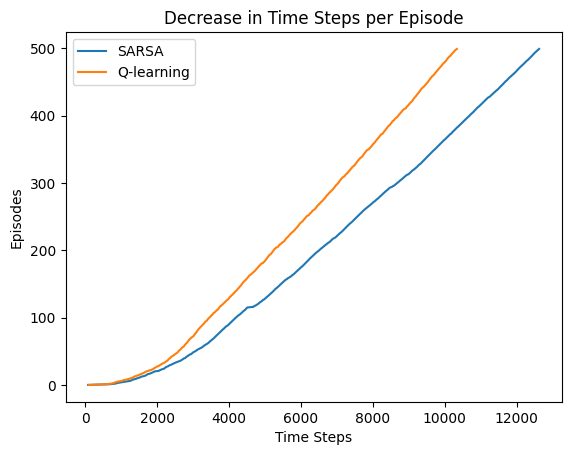

In [17]:
plt.plot(sarsa_timesteps, range(len(sarsa_timesteps)), label="SARSA", linestyle='-')
plt.plot(q_learning_timesteps, range(len(q_learning_timesteps)),label="Q-learning", linestyle='-')
# Labels
plt.xlabel("Time Steps")
plt.ylabel("Episodes")
plt.title("Decrease in Time Steps per Episode")
plt.legend()  # Show legend


# Show the plot
plt.show()

# SARSA Walk

In [35]:
fig, ax = plt.subplots()
frame_display = ax.imshow(sarsa_walk[0])  # Start with the first frame

def update(frame):
    frame_display.set_array(frame)
    return [frame_display]

ani = animation.FuncAnimation(fig, update, frames=sarsa_walk, interval=50, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())

# Q Learning Walk

In [36]:
fig, ax = plt.subplots()
frame_display = ax.imshow(q_learning_walk[0])  # Start with the first frame

ani = animation.FuncAnimation(fig, update, frames=q_learning_walk, interval=50, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())

# Online Learning Intuition

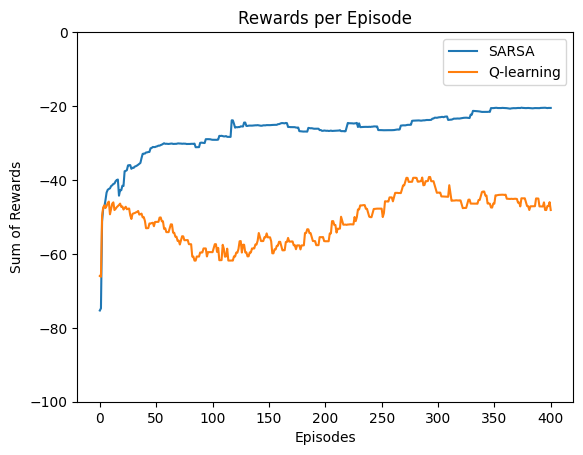

In [31]:
def moving_avg(arr, window_size=100):
    return np.convolve(arr, np.ones(window_size) / window_size, mode='valid')

sarsa_rewards_avg = moving_avg(sarsa_rewards)
q_learning_rewards_avg = moving_avg(q_learning_rewards)


plt.plot(range(len(sarsa_rewards_avg)), sarsa_rewards_avg, label='SARSA', linestyle='-')
plt.plot(range(len(q_learning_rewards_avg)), q_learning_rewards_avg, label='Q-learning', linestyle='-')
plt.ylim(-100, 0)
# Labels
plt.xlabel("Episodes")
plt.ylabel("Sum of Rewards")
plt.title("Rewards per Episode")
plt.legend()  # Show legend


# Show the plot
plt.show()

# Summary

## *Learning the optimal route quickly is not always in our best interest*

### We need to know if our online decisions matter on the route to learning the optimal policy

### **Was the result to time tradeoff worth the journey?**